In [1]:
import netCDF4 as nc4
# from scipy.io import netcdf as nc
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import axes3d
import copy
import pandas as pd
import time as tm
import xarray as xr
import mpl_toolkits as mpl
# import plotly.graph_objects as go
# import plotly.express as px
from scipy import interpolate


### Predefined functions

In [7]:
def moving_average(a, n=10) :
    """
    Quick moving average function
    # a - input array
    # n - the window of moving average
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [146]:
arr_vegc_rec = copy.deepcopy(arr_vegc)

In [148]:
np.shape(arr_vegc_rec)

(27L, 2160L, 1L)

In [150]:
arr_vegc_rec[:,2040,0]

array([13.037875 ,  8.271657 , 11.051495 , 12.019691 ,  8.849665 ,
        9.98863  , 12.55343  ,  5.8730493,  7.6329336,  4.451742 ,
       15.837354 , 19.514715 , 16.26207  ,  8.597652 ,  6.477855 ,
        6.477855 , 11.324023 ,  9.155343 , 12.479699 ,  9.8154955,
       14.337709 , 14.0355015, 14.11811  ,  8.848938 , 13.515265 ,
       17.110163 , 11.15167  ], dtype=float32)

In [156]:
arr_vegc[:,2100,0]/arr_vegc_rec[:,2100,0]

array([0.5971656 , 0.59574467, 0.59480524, 0.59382933, 0.5966692 ,
       0.5967951 , 0.5928452 , 0.59218407, 0.59700745, 0.59249276,
       0.5970002 , 0.5967566 , 0.6002808 , 0.6011021 , 0.6014968 ,
       0.6014968 , 0.59309554, 0.59639007, 0.5982193 , 0.5945112 ,
       0.60005224, 0.60058814, 0.5971144 , 0.5932927 , 0.5940046 ,
       0.5963911 , 0.596736  ], dtype=float32)

### Read in history output

In [2]:
candidates = np.array([18, 135, 267, 291, 331, 352, 386, 420, 463, 471, 519, 541, 567, 834, 
                       883, 916, 938, 994, 1006, 1068, 1241, 1246, 1374, 1431, 1500, 1530, 1580])-1

# candidates = np.array([1374])-1

In [147]:
# Open the file and obtain the last value
# This step will take much longer than expected.
start = tm.time()

# nens = len(candidates)
nens = 27

get_mean = False
# Path to all ensemble members
block_path = './hist_test_logging/'
block_prefix = 'fates_candidates27_logging_2024-04-22_e9515ed7a8_5d40c9e6.elm_'
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_candidates27_logging_2024-05-03_e9515ed7a8_21b9c164/run/'
# block_prefix = 'fates_candidates27_logging_2024-05-03_e9515ed7a8_21b9c164.elm_'
# block_path = '/pscratch/sd/s/sshu3/FATES_MRV/fates_mergetest_logging_2024-05-10_e9515ed7a8_664db78d/run/'
# block_prefix = 'fates_mergetest_logging_2024-05-10_e9515ed7a8_664db78d.elm_'
fyear = [1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885, 1890, 1895 
         , 1890, 1895, 1900, 1905, 1910, 1915, 1920
         , 1925, 1930, 1935, 1940, 1945
         , 1950, 1955, 1960, 1965, 1970, 1975, 1980
         , 1985, 1990, 1995, 2000, 2005, 2010, 2015]
nyr = len(fyear)*5
    
# Var lists
num_sz_collect = []
time_collect = []
gpp_collect = []
gpp_bl_collect = []
gpp_nl_collect = []
npp_collect = []
npp_bl_collect = []
npp_nl_collect = []
age_patch_collect = []
age_collect = []
can_area_collect = []
lai_collect = []
lai_age_collect = []
vegc_collect = []
vegc_bl_collect = []
vegc_nl_collect = []
leafc_collect = []
leafc_bl_collect = []
leafc_nl_collect = []
reprodc_collect = []
sapwoodc_collect = []
storec_collect = []
frc_collect = []
rec_collect = []
mort_collect = []
mort_ustory_collect = []
ba_collect = []
num_can_sz_collect = []
num_ustory_sz_collect = []
ddbh_can_sz_collect = []
ddbh_ustory_sz_collect = []
litter_collect = []
spread_collect = []
soilc_collect = []
logging_rate_collect = []
sec_frac_collect = []

# Open one file to get some metadata
fpath = block_path+block_prefix+'0001.h0.'+str(fyear[0])+'-02-01-00000.nc'
dtc = nc4.Dataset(fpath)
patch_age_bins = dtc['fates_levage'][:]
cohort_size_bins = dtc['fates_levscls'][:]
dtc.close()

# Loop through members and collect the time series
# for i in np.arange(0,len(candidates)):
for i in np.arange(0,nens):
    for j in np.arange(0, len(fyear)):
        ens_num = str(i+1).zfill(4)
#     print('Current block number: ', k)
#     print('Current ens_num number: ', ens)
        fpath = block_path+block_prefix+ens_num+'.h0.'+str(fyear[j])+'-02-01-00000.nc'
        dtc = nc4.Dataset(fpath)
        dtime = dtc['time'][:]
        dnum_sz = dtc['FATES_NPLANT_SZ'][:]
        dgpp = dtc['FATES_GPP'][:]
        dgpp_pf = dtc['FATES_GPP_PF'][:]
        dnpp = dtc['FATES_NPP'][:]
        dnpp_pf = dtc['FATES_NPP_PF'][:]
        dlai = dtc['FATES_LAI'][:]
        dlai_age = dtc['FATES_LAI_AP'][:]
        dleafc = dtc['FATES_LEAFC'][:]
        dleafc_pf = dtc['FATES_LEAFC_PF'][:]
        dvegc = dtc['FATES_VEGC'][:]
        dvegc_pf = dtc['FATES_VEGC_PF'][:]
        dreprodc = dtc['FATES_REPROC'][:]
        dsapwoodc = dtc['FATES_SAPWOODC'][:]
        dstorec = dtc['FATES_STOREC'][:]
        dfrc = dtc['FATES_FROOTC'][:]
        drec = dtc['FATES_RECRUITMENT_PF'][:]
        dmort = dtc['FATES_MORTALITY_CANOPY_SZ'][:]
        dmort_ustory = dtc['FATES_MORTALITY_USTORY_SZ'][:]
        dba = dtc['FATES_BASALAREA_SZ'][:]
        dnum_can_sz = dtc['FATES_NPLANT_CANOPY_SZ'][:]
        dnum_ustory_sz = dtc['FATES_NPLANT_USTORY_SZ'][:]
        ddbh_can_sz = dtc['FATES_DDBH_CANOPY_SZ'][:]
        ddbh_ustory_sz = dtc['FATES_DDBH_USTORY_SZ'][:]
        dlitter = dtc['FATES_LITTER_OUT'][:]
        dsoilc = dtc['TOTSOMC_1m'][:]
        dspread = dtc['FATES_CANOPY_SPREAD'][:]
        dage_patch = dtc['FATES_PATCHAREA_AP'][:]
        dage = dtc['FATES_SECONDAREA_ANTHRODIST_AP'][:]
        dcan_area = dtc['FATES_CANOPYAREA_AP'][:]
        dlogging_rate = dtc['FATES_DISTURBANCE_RATE_LOGGING'][:]
        dsec_frac = dtc['FATES_SECONDARY_FOREST_FRACTION'][:]
        dtc.close()
        
        # Concatenate into same time series
        if(j == 0):
            dtime_comb = copy.deepcopy(dtime)
            dgpp_comb = copy.deepcopy(dgpp)
            dgpp_pf_comb = copy.deepcopy(dgpp_pf)
            dnpp_comb = copy.deepcopy(dnpp)
            dnpp_pf_comb = copy.deepcopy(dnpp_pf)
            dlai_comb = copy.deepcopy(dlai)
            dlai_age_comb = copy.deepcopy(dlai_age)
            dleafc_comb = copy.deepcopy(dleafc)
            dleafc_pf_comb = copy.deepcopy(dleafc_pf)
            dvegc_comb = copy.deepcopy(dvegc)
            dvegc_pf_comb = copy.deepcopy(dvegc_pf)
            dreprodc_comb = copy.deepcopy(dreprodc)
            dsapwoodc_comb = copy.deepcopy(dsapwoodc)
            dstorec_comb = copy.deepcopy(dstorec)
            dfrc_comb = copy.deepcopy(dfrc)
            drec_comb = copy.deepcopy(drec)
            dmort_comb = copy.deepcopy(dmort)
            dmort_ustory_comb = copy.deepcopy(dmort_ustory)
            dba_comb = copy.deepcopy(dba)
            dnum_sz_comb = copy.deepcopy(dnum_sz)
            dnum_can_sz_comb = copy.deepcopy(dnum_can_sz)
            dnum_ustory_sz_comb = copy.deepcopy(dnum_ustory_sz)
            ddbh_can_sz_comb = copy.deepcopy(ddbh_can_sz)
            ddbh_ustory_sz_comb = copy.deepcopy(ddbh_ustory_sz)
            dlitter_comb = copy.deepcopy(dlitter)
            dspread_comb = copy.deepcopy(dspread)
            dsoilc_comb = copy.deepcopy(dsoilc)
            dage_patch_comb = copy.deepcopy(dage_patch)
            dage_comb = copy.deepcopy(dage)
            dcan_area_comb = copy.deepcopy(dcan_area)
            dlogging_rate_comb = copy.deepcopy(dlogging_rate)
            dsec_frac_comb = copy.deepcopy(dsec_frac)
        else:
            dtime_comb = np.append(dtime_comb, dtime, axis = 0)
            dgpp_comb = np.append(dgpp_comb, dgpp, axis = 0)
            dgpp_pf_comb = np.append(dgpp_pf_comb, dgpp_pf, axis = 0)
            dnpp_comb = np.append(dnpp_comb, dnpp, axis = 0)
            dnpp_pf_comb = np.append(dnpp_pf_comb, dnpp_pf, axis = 0)
            dlai_comb = np.append(dlai_comb, dlai, axis = 0)
            dlai_age_comb = np.append(dlai_age_comb, dlai_age, axis = 0)
            dleafc_comb = np.append(dleafc_comb, dleafc, axis = 0)
            dleafc_pf_comb = np.append(dleafc_pf_comb, dleafc_pf, axis = 0)
            dvegc_comb = np.append(dvegc_comb, dvegc, axis = 0)
            dvegc_pf_comb = np.append(dvegc_pf_comb, dvegc_pf, axis = 0)
            dreprodc_comb = np.append(dreprodc_comb, dreprodc, axis = 0)
            dsapwoodc_comb = np.append(dsapwoodc_comb, dsapwoodc, axis = 0)
            dstorec_comb = np.append(dstorec_comb, dstorec, axis = 0)
            dfrc_comb = np.append(dfrc_comb, dfrc, axis = 0)
            drec_comb = np.append(drec_comb, drec, axis = 0)
            dmort_comb = np.append(dmort_comb, dmort, axis = 0)
            dmort_ustory_comb = np.append(dmort_ustory_comb, dmort_ustory, axis = 0)
            dba_comb = np.append(dba_comb, dba, axis = 0)
            dnum_sz_comb = np.append(dnum_sz_comb, dnum_sz, axis = 0)
            dnum_can_sz_comb = np.append(dnum_can_sz_comb, dnum_can_sz, axis = 0)
            dnum_ustory_sz_comb = np.append(dnum_ustory_sz_comb, dnum_ustory_sz, axis = 0)
            ddbh_can_sz_comb = np.append(ddbh_can_sz_comb, ddbh_can_sz, axis = 0)
            ddbh_ustory_sz_comb = np.append(ddbh_ustory_sz_comb, ddbh_ustory_sz, axis = 0)
            dlitter_comb = np.append(dlitter_comb, dlitter, axis = 0)
            dspread_comb = np.append(dspread_comb, dspread, axis = 0)
            dsoilc_comb = np.append(dsoilc_comb, dsoilc, axis = 0)
            dage_patch_comb = np.append(dage_patch_comb, dage_patch, axis=0)
            dage_comb = np.append(dage_comb, dage, axis = 0)
            dcan_area_comb = np.append(dcan_area_comb, dcan_area, axis = 0)
            dlogging_rate_comb = np.append(dlogging_rate_comb, dlogging_rate, axis=0)
            dsec_frac_comb = np.append(dsec_frac_comb, dsec_frac, axis=0)

    # Obtain the mean results
    if(get_mean):
        num_sz_collect.append(np.nanmean(dnum_sz[:,:,0], axis = 1))
        time_collect.append(np.nanmean(dtime[:]))
        gpp_collect.append(np.nanmean(dgpp[:,0])*3600*24*365)
        gpp_bl_collect.append(np.nanmean(dgpp_pf[:,0,0])*3600*24*365)
        gpp_nl_collect.append(np.nanmean(dgpp_pf[:,1,0])*3600*24*365)
        npp_collect.append(np.nanmean(dnpp[:,0])*3600*24*365)
        npp_bl_collect.append(np.nanmean(dnpp_pf[:,0,0])*3600*24*365)
        npp_nl_collect.append(np.nanmean(dnpp_pf[:,1,0])*3600*24*365)
        lai_collect.append(np.nanmean(dlai[:,0]))
        lai_age_collect.append(np.nanmean(np.nansum(dlai_age[:,:,0], axis=1)))
        leafc_collect.append(np.nanmean(dleafc[:,0]))
        leafc_bl_collect.append(np.nanmean(dleafc_pf[:,0,0]))
        leafc_nl_collect.append(np.nanmean(dleafc_pf[:,1,0]))
        vegc_collect.append(np.nanmean(dvegc[:,0]))
        vegc_bl_collect.append(np.nanmean(dvegc_pf[:,0,0]))
        vegc_nl_collect.append(np.nanmean(dvegc_pf[:,1,0]))
        reprodc_collect.append(np.nanmean(dreprodc[:,0]))
        sapwoodc_collect.append(np.nanmean(dsapwoodc[:,0]))
        storec_collect.append(np.nanmean(dstorec[:,0]))
        frc_collect.append(np.nanmean(dfrc[:,0]))
        rec_collect.append(np.nanmean(np.nansum(drec[:,:,0], axis=1)))
        mort_collect.append(np.nanmean(np.nansum(dmort[:,:,0], axis=1)))
        mort_ustory_collect.append(np.nanmean(np.nansum(dmort_ustory[:,:,0], axis=1)))
        ba_collect.append(np.nanmean(np.nansum(dba[:,:,0], axis=1)))
        num_can_sz_collect.append(np.nanmean(np.nansum(dnum_can_sz[:,:,0], axis=1)))
        num_ustory_sz_collect.append(np.nanmean(np.nansum(dnum_ustory_sz[:,:,0], axis=1)))
        ddbh_can_sz_collect.append(np.nanmean(np.nansum(ddbh_can_sz[:,:,0], axis=1)))
        ddbh_ustory_sz_collect.append(np.nanmean(np.nansum(ddbh_ustory_sz[:,:,0], axis=1)))
        litter_collect.append(np.nanmean(dlitter[:,0]))
        soilc_collect.append(np.nanmean(dsoilc[:,0]*0.001))
        spread_collect.append(np.nanmean(dspread[:,0]))
        age_patch_collect.append(np.nanmean(np.nansum(dage_patch[:,:,0], axis=1)))
        age_collect.append(np.nanmean(np.nansum(dage[:,:,0], axis=1)))
        can_area_collect.append(np.nanmean(np.nansum(dcan_area[:,:,0], axis=1)))
        logging_rate_collect.append(np.nanmean(np.nansum(dlogging_rate[:,0], axis=0)))
        sec_frac_collect.append(np.nanmean(np.nansum(dsec_frac[:,0], axis=0)))
    else:
        # Obtain the time series
        time_collect.append(dtime_comb[:])
        num_sz_collect.append(dnum_sz_comb[:,:])
        gpp_collect.append(dgpp_comb[:]*3600*24*365)
        gpp_bl_collect.append(dgpp_pf_comb[:,0]*3600*24*365)
        gpp_nl_collect.append(dgpp_pf_comb[:,1]*3600*24*365)
        npp_collect.append(dnpp_comb[:]*3600*24*365)
        npp_bl_collect.append(dnpp_pf_comb[:,0]*3600*24*365)
        npp_nl_collect.append(dnpp_pf_comb[:,1]*3600*24*365)
        lai_collect.append(dlai_comb[:])
        lai_age_collect.append(dlai_age_comb[:,:])
        leafc_collect.append(dleafc_comb[:])
        leafc_bl_collect.append(dleafc_pf_comb[:,0])
        leafc_nl_collect.append(dleafc_pf_comb[:,1])
        vegc_collect.append(dvegc_comb[:])
        vegc_bl_collect.append(dvegc_pf_comb[:,0])
        vegc_nl_collect.append(dvegc_pf_comb[:,1])
        reprodc_collect.append(dreprodc_comb[:])
        sapwoodc_collect.append(dsapwoodc_comb[:])
        storec_collect.append(dstorec_comb[:])
        frc_collect.append(dfrc_comb[:])
        rec_collect.append(drec_comb[:,:])
        mort_collect.append(dmort_comb[:,:])
        mort_ustory_collect.append(dmort_ustory_comb[:,:])
        ba_collect.append(dba_comb[:,:])
        num_can_sz_collect.append(dnum_can_sz_comb[:,:])
        num_ustory_sz_collect.append(dnum_ustory_sz_comb[:,:])
        ddbh_can_sz_collect.append(ddbh_can_sz_comb[:,:])
        ddbh_ustory_sz_collect.append(ddbh_ustory_sz_comb[:,:])
        litter_collect.append(dlitter_comb[:])
        spread_collect.append(dspread_comb[:])
        soilc_collect.append(dsoilc_comb[:]*0.001)
        age_patch_collect.append(dage_patch_comb[:,:])
        age_collect.append(dage_comb[:,:])
        can_area_collect.append(dcan_area_comb[:,:])
        logging_rate_collect.append(dlogging_rate_comb[:])
        sec_frac_collect.append(dsec_frac_comb[:])
    
# transfer into np array 
arr_num_sz = np.array(num_sz_collect)
arr_time = np.array(time_collect)
arr_gpp = np.array(gpp_collect)
arr_gpp_bl = np.array(gpp_bl_collect)
arr_gpp_nl = np.array(gpp_nl_collect)
arr_npp = np.array(npp_collect)
arr_npp_bl = np.array(npp_bl_collect)
arr_npp_nl = np.array(npp_nl_collect)
arr_lai = np.array(lai_collect)
arr_lai_age = np.array(lai_age_collect)
arr_leafc = np.array(leafc_collect)
arr_leafc_bl = np.array(leafc_bl_collect)
arr_leafc_nl = np.array(leafc_nl_collect)
arr_vegc = np.array(vegc_collect)
arr_vegc_bl = np.array(vegc_bl_collect)
arr_vegc_nl = np.array(vegc_nl_collect)
arr_reprodc = np.array(reprodc_collect)
arr_sapwoodc = np.array(sapwoodc_collect)
arr_storec = np.array(storec_collect)
arr_frc = np.array(frc_collect)
arr_rec = np.array(rec_collect)
arr_mort = np.array(mort_collect)
arr_mort_ustory = np.array(mort_ustory_collect)
arr_ba = np.array(ba_collect)
arr_num_can_sz = np.array(num_can_sz_collect)
arr_num_ustory_sz = np.array(num_ustory_sz_collect)
arr_ddbh_can_sz = np.array(ddbh_can_sz_collect)
arr_ddbh_ustory_sz = np.array(ddbh_ustory_sz_collect)
arr_spread = np.array(spread_collect)
arr_litter = np.array(litter_collect)
arr_soilc = np.array(soilc_collect)
arr_age_patch = np.array(age_patch_collect)
arr_age = np.array(age_collect)
arr_can_area = np.array(can_area_collect)
arr_logging_rate = np.array(logging_rate_collect)
arr_sec_frac = np.array(sec_frac_collect)

end = tm.time()
print('Time elapsed: ', end - start)

('Time elapsed: ', 46.14300012588501)


In [6]:
# Open tree measurements
df_full  = pd.read_csv('Tree_measurements.csv', low_memory=False)


In [17]:
# Get DBH vs. biomass correlation
dbh_obs = np.array(df_full.Final_DBH_cm)
ba_obs = np.array(df_full.Basal_Area)
vegc_obs = np.array(df_full.Biomass_kg)*0.5

# check the barplot of binned DBH
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## because the bin edges read in define the lower edges, add a last index to each to
## represent the upper edge of the distribution (even though there isn't one, really)
# time = np.append(time,time[ntim-1]+31.0)
patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)
cohort_size_bins = np.array([0.00000000e+00, 7.50000000e+00, 1.50000000e+01,
                   2.00000000e+01, 3.00000000e+01, 4.00000000e+01,
                   5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
                   8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
                   110, 120])

In [31]:
df_full.head()

,Date,Plot_ID,Species,Final_DBH_cm,Basal_Area,Biomass_kg,Final,Height_m,Lat,Long
0,03/09/24,5,Fir,35.56,0.099315,595.577427,16.56,19.254539,-98.624797,NaN
1,03/09/24,5,Alder,33.02,0.085634,289.619911,5.44,-999.000000,-999.000000,NaN
2,03/09/24,5,Fir,76.20,0.456037,4043.190358,-999.00,-999.000000,-999.000000,NaN
3,03/09/24,5,Fir,38.10,0.114009,708.330283,-999.00,-999.000000,-999.000000,NaN
4,03/09/24,5,Fir,22.86,0.041043,196.213960,-999.00,-999.000000,-999.000000,NaN


In [59]:
# divide into size bins
sizebins = [7.5, 15, 20, 30, 40, 50, 60, 70]

# Nb divide by X to get it per ha

binned = pd.cut(dbh_obs, bins=sizebins)
bin_counts_all = binned.value_counts()
obs_sz_frac = bin_counts_all.values/np.float(np.sum(bin_counts_all.values))



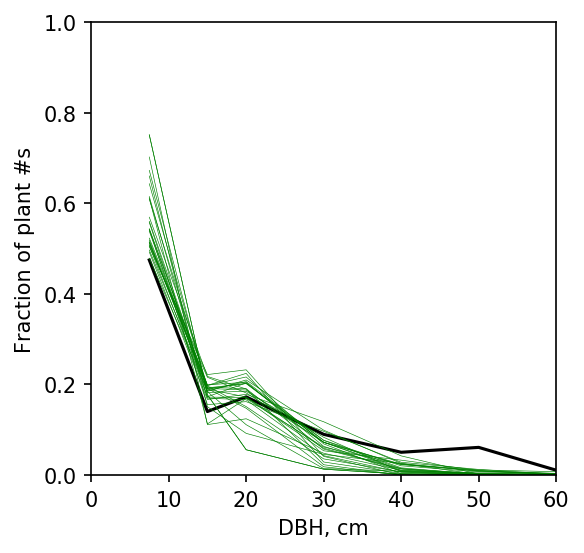

In [62]:
fig = plt.figure(figsize=(4,4), dpi=150)
lower_bin_edge_obs = np.array([7.5, 15, 20, 30, 40, 50, 60])
lower_bin_edge_ens = np.array([0, 7.5, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150])
plt.plot(lower_bin_edge_obs, obs_sz_frac, 'k-')
plt.xlim([0.0, 60.0])
plt.ylim([0.0, 1.0])
plt.xlabel('DBH, cm')
plt.ylabel('Fraction of plant #s')
for i in np.arange(0, len(candidates)):
    ens_sz_frac = arr_num_sz[i,2040,1:13,0]/np.sum(arr_num_sz[i,2040,1:13,0])
    plt.plot(lower_bin_edge_ens[1:13], ens_sz_frac, 'g-', linewidth=0.3)
    

(0, 65)

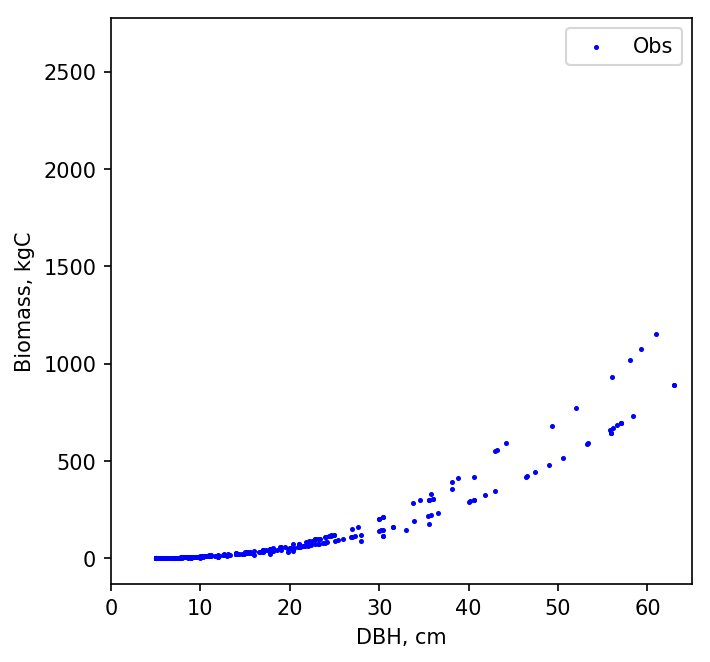

In [80]:
# Check DBH vs. biomass correlation
# Requires the biomass output by size
fig = plt.figure(figsize=(5,5), dpi=150)
plt.xlabel('DBH, cm')
plt.ylabel('Biomass, kgC')
plt.scatter(dbh_obs, vegc_obs,  c='blue', s=2)
plt.legend(['Obs'])
plt.xlim([0, 65])
# for i in np.arange(0, len(candidates)):
#     plt.plot(lower_bin_edge_ens[1:13], arr_vegc_nl_mean[i,170,0]+arr_vegc_bl_mean[i,170,0])

In [91]:
# Check the biomass ratio between NL and BL
vegc_fir = np.array(df_full.Biomass_kg[df_full.Species == 'Fir'])*0.5
vegc_pine = np.array(df_full.Biomass_kg[df_full.Species == 'Pine'])*0.5
vegc_alder = np.array(df_full.Biomass_kg[df_full.Species == 'Alder'])*0.5
vegc_oak = np.array(df_full.Biomass_kg[df_full.Species == 'Oak'])*0.5

vegc_nl = np.nanmean(np.concatenate((vegc_fir, vegc_pine)))
vegc_bl = np.nanmean(np.concatenate((vegc_alder, vegc_oak)))

# Check Needle leaf vs. broad leaf ratio
fig = plt.figure(figsize=(5,5), dpi=150)
for i in np.arange(0,nens):
    plt.scatter(arr_vegc_nl_mean[i,170], arr_vegc_bl_mean[i,170], s=5)
# plt.legend(['1', '2', '3', '4', '5'])
plt.scatter([4.22], [4.97], color='k')
plt.xlabel('Needle leaf, kgC m-2')
plt.ylabel('Broad leaf, kgC m-2')

### Selected candidates

In [142]:
# NL [3.376, 5.064]: #3, #5, #6, #8, #9, #10
# BL [3.976, 5.964]: #5, #7, #12, #13, #17, #19, #20
candidates_nl = np.array([267, 331, 352, 420, 463, 471]) - 1
candidates_bl = np.array([331, 386, 541, 567, 938, 1006, 1068]) - 1
# Pick NL
candidates = candidates_nl
Get_candidates = True

In [143]:
# List of parameters with certain perturbation
param_ranges_full = pd.read_csv('sr_ppe_params.csv')
param_ranges = param_ranges_full[['param', 'value_mean', 'value_min', 'value_max', 'pft', 'organ']]

# number of parameters
n_params = len(param_ranges)

# number of PFTs - some are global so subtract one
n_pfts = len(pd.unique(param_ranges['pft'])) - 1

param_names = list(param_ranges.param)
pfts = list(param_ranges.pft)
organs = list(param_ranges.organ)

# print(param_ranges)
param_needle = param_names[0:12] + param_names[13:38]
param_broad = param_names[40:len(param_names)]
param_nopft = [param_names[12]]+ param_names[38:40]


In [144]:
# Only obtain parameter values from candidates

# Settings
param_value = []
broad_pft = 0
needle_pft = 1

# Choose a PFT or obtain all PFTs (pft_pick == -1)
pft_picked = 1

# Open and collect all parameter information from candidates within the ensemble
# Path to all members
param_prefix = 'parameter_file_sandbox/fates_params_sr_ens_'
for i in np.arange(0,1600):
    if(pft_picked == -1):
        for j in np.arange(0, len(candidates_max)):
            param_sample = []
            if (i == candidates_max[j]):
                if (Get_candidates):
                    print('Current candidate number: ', i+1)
                ens_num = str(candidates_max[j]+1).zfill(4)
                fpath = param_prefix+ens_num+'.nc'
                dtc = nc4.Dataset(fpath)
                for k in np.arange(0, len(param_needle)):
                    tmp = dtc[param_needle[k]][:]
                    # Either 1D or 2D
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[needle_pft])
                    else:
                        param_sample.append(tmp[0,needle_pft])
                for k in np.arange(0, len(param_broad)):
                    tmp = dtc[param_broad[k]][:]
                    # Either 1D or 2D
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[broad_pft])
                    else:
                        param_sample.append(tmp[0,broad_pft])
                for k in np.arange(0, len(param_nopft)):
                    tmp = dtc[param_nopft[k]][:]
                    if (len(np.shape(tmp)) == 1):
                        param_sample.append(tmp[0])
                    else:
                        param_sample.append(tmp)
                dtc.close()
                param_value.append(param_sample)
    else:
        for j in np.arange(0, len(candidates)):
            param_sample = []
            if (i == candidates[j]):
                if (Get_candidates):
                    print('Current candidate number: ', i+1)
                ens_num = str(candidates[j]+1).zfill(4)
                fpath = param_prefix+ens_num+'.nc'
                dtc = nc4.Dataset(fpath)
                if(pft_picked == needle_pft):
                    for k in np.arange(0, len(param_needle)):
                        tmp = dtc[param_needle[k]][:]
                        # Either 1D or 2D
                        if (len(np.shape(tmp)) == 1):
                            param_sample.append(tmp[needle_pft])
                        else:
                            param_sample.append(tmp[0,needle_pft])
                    for k in np.arange(0, len(param_nopft)):
                        tmp = dtc[param_nopft[k]][:]
                        if (len(np.shape(tmp)) == 1):
                            param_sample.append(tmp[0])
                        else:
                            param_sample.append(tmp)
                if(pft_picked == broad_pft):
                    for k in np.arange(0, len(param_broad)):
                        tmp = dtc[param_broad[k]][:]
                        # Either 1D or 2D
                        if (len(np.shape(tmp)) == 1):
                            param_sample.append(tmp[broad_pft])
                        else:
                            param_sample.append(tmp[0,broad_pft])
                    for k in np.arange(0, len(param_nopft)):
                        tmp = dtc[param_nopft[k]][:]
                        if (len(np.shape(tmp)) == 1):
                            param_sample.append(tmp[0])
                        else:
                            param_sample.append(tmp)
                dtc.close()
                param_value.append(param_sample)
  
# Merge all parameter information to a list
arr_param_value = np.array(param_value)
param_candidate_min = []
param_candidate_mean = []
param_candidate_max = []
# Get min/max range of each parameter
if(pft_picked == broad_pft):
    param_all = param_broad+param_nopft
else:
    if(pft_picked == needle_pft):
        param_all = param_needle+param_nopft
    else:
        param_all = param_needle+param_broad+param_nopft
for i in np.arange(0, len(param_all)):
    if (len(np.shape(arr_param_value)) == 1):
        param_candidate_min.append(np.nanmin(arr_param_value[i]))
        param_candidate_max.append(np.nanmax(arr_param_value[i]))
        param_candidate_mean.append(np.nanmean(arr_param_value[i]))
    else:
        param_candidate_min.append(np.nanmin(arr_param_value[:,i]))
        param_candidate_max.append(np.nanmax(arr_param_value[:,i]))
        param_candidate_mean.append(np.nanmean(arr_param_value[:,i]))

del tmp

('Current candidate number: ', 267)
('Current candidate number: ', 331)
('Current candidate number: ', 352)
('Current candidate number: ', 420)
('Current candidate number: ', 463)
('Current candidate number: ', 471)


In [134]:
np.shape(param_value)

(7L, 40L)

### Diagnose age structure

In [94]:
## Calculate annual average
age_annual_mean = np.zeros((nens,nyr,51))
age_patch_mean = np.zeros((nens,nyr,51))
arr_gpp_nl_mean = np.zeros((nens,nyr))
arr_gpp_bl_mean = np.zeros((nens,nyr))
arr_vegc_nl_mean = np.zeros((nens,nyr))
arr_vegc_bl_mean = np.zeros((nens,nyr))
arr_soilc_mean = np.zeros((nens,nyr))
arr_logging_rate_mean = np.zeros((nens,nyr))
arr_sec_frac_mean = np.zeros((nens,nyr))
for iyr in np.arange(0,nyr):
    age_annual_mean[:,iyr,:] = np.nanmean(arr_age[:,12*iyr:12+12*iyr,:,0], axis=1)
    age_patch_mean[:,iyr,:] = np.nanmean(arr_age_patch[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_gpp_nl_mean[:,iyr] = np.nanmean(arr_gpp_nl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_gpp_bl_mean[:,iyr] = np.nanmean(arr_gpp_bl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_vegc_nl_mean[:,iyr] = np.nanmean(arr_vegc_nl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_vegc_bl_mean[:,iyr] = np.nanmean(arr_vegc_bl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_soilc_mean[:,iyr] = np.nanmean(arr_soilc[:,12*iyr:12+12*iyr,0], axis=1)
    arr_logging_rate_mean[:,iyr] = np.nanmean(arr_logging_rate[:,12*iyr:12+12*iyr,0], axis=1)
    arr_sec_frac_mean[:,iyr] = np.nanmean(arr_sec_frac[:,12*iyr:12+12*iyr,0], axis=1)

# Age structure   
age_bin = np.arange(1,52)
ax_yr = np.arange(1850,1850+nyr)
age_yr = np.zeros((nens,nyr))
for iyr in np.arange(0,nyr):
    for j in np.arange(0,nens):
        for k in np.arange(0,51):
            age_yr[j,iyr] = age_yr[j,iyr] + age_bin[k] * age_annual_mean[j,iyr,k]

In [31]:
## Open and read in harvest rate data
flanduse = '/pscratch/sd/s/sshu3/FATES_MRV/fates_candidates27_2024-03-13_e9515ed7a8_5d40c9e6/run/landuse.timeseries_0.125x0.125_hist_simyr1850-2015.SanRafael.c231020.nc'
dtc = nc4.Dataset(flanduse)
hrv1 = np.squeeze(np.array(dtc['HARVEST_VH1'][:]))
hrs1 = np.squeeze(np.array(dtc['HARVEST_SH1'][:]))
hrs2 = np.squeeze(np.array(dtc['HARVEST_SH2'][:]))
dtc.close()


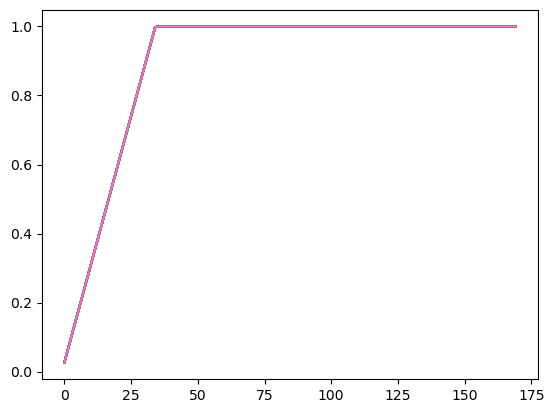

In [6]:
## Look at the secondary forest fraction
for i in np.arange(0, nens):
    plt.plot(arr_sec_frac_mean[i,:])

(0.0, 0.1)

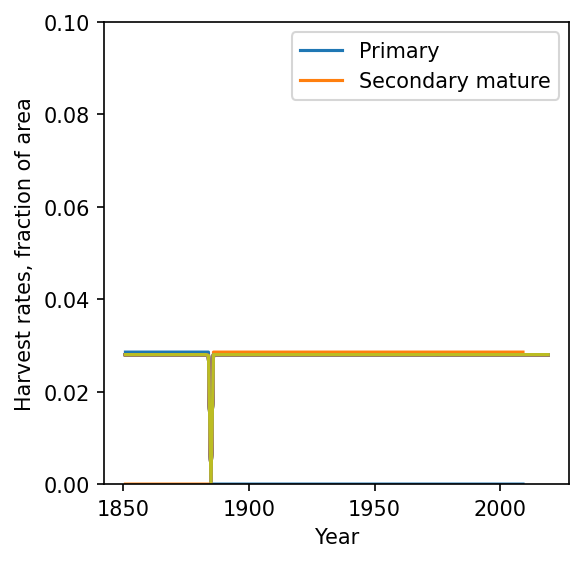

In [7]:
## Check harvest rates from FATES

fig = plt.figure(figsize=(4,4), dpi=150)
# ax_yr = np.arange(1850,2016)
plt.plot(ax_yr[1:160], hrv1[3:162])
plt.plot(ax_yr[1:160], hrs1[2:161])
for i in np.arange(0,27):
    plt.plot(ax_yr[1:nyr], arr_logging_rate_mean[i, 1:nyr])
plt.legend(['Primary', 'Secondary mature'])
plt.xlabel('Year')
plt.ylabel('Harvest rates, fraction of area')
plt.ylim([0, 0.1])

In [18]:
# Here we directly paste the results from hypothetical age model. 
# Shall think about putting model into module
hyperthetical_curve_noweight = [0.999999000001, 1.499999250000375, 1.9999993333335557, 2.4999993750001566,
 2.9999994000001204, 3.4999994166667645, 3.9999994285715115, 4.499999437500072, 4.999999444444508,
 5.499999450000057, 6.499999350000066, 7.4999992500000765, 8.499999150000086, 9.499999050000097,
 10.499998950000109, 11.499998850000118, 12.499998750000128, 13.499998650000139, 14.499998550000148,
 15.49999845000016, 16.49999835000017, 17.499998250000182, 18.49999815000019, 19.4999980500002,
 20.49999795000021, 21.499997850000216, 22.499997750000226, 23.49999765000024, 24.499997550000252,
 25.499997450000265, 26.499997350000275, 27.49999725000028, 28.49999715000029, 29.4999970500003,
 30.499996950000313, 30.499997949999212, 30.488093776784428, 30.464284672185645, 30.428570713334334,
 30.380951934593714]

hyperthetical_curve = [0.02857133,  0.08571414,  0.17142837,  0.28571404,  0.42857113,
        0.59999965,  0.7999996 ,  1.02857098,  1.28571379,  1.57142802,
        1.88571369,  2.22857078,  2.5999993 ,  2.99999925,  3.42857063,
        3.88571344,  4.37142767,  4.88571334,  5.42857043,  5.99999895,
        6.5999989 ,  7.22857028,  7.88571309,  8.57142732,  9.28571299,
       10.02857008, 10.7999986 , 11.59999855, 12.42856993, 13.28571274,
       14.17142697, 15.08571264, 16.02856973, 16.99999825, 17.9999982 ,
       18.0000017 , 18.0000051 , 18.0000084 , 18.0000116 , 18.0000147 ,
       18.0000177 , 18.0000206 , 18.0000234 , 18.0000261 , 18.0000287 ,
       18.0000312 , 18.0000336 , 18.0000359 , 18.0000381 , 18.0000402 ,
       18.0000422 , 18.0000441 , 18.0000459 , 18.0000476 , 18.0000492 ,
       18.0000507 , 18.0000521 , 18.0000534 , 18.0000546 , 18.0000557 ,
       18.0000567 , 18.0000576 , 18.0000584 , 18.0000591 , 18.0000597 ,
       18.0000602 , 18.0000606 , 18.0000609 , 18.0000611 , 18.0000612 ,
       18.00006119, 18.00006119, 18.00006119, 18.00006119, 18.00006119]

hyper_age_dist = np.array([2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 1.59986841e-06,
       8.39866247e-11, 4.11504936e-15, 1.87222296e-19, 7.86285482e-24,
       3.02702959e-28, 1.05940659e-32, 3.33697893e-37, 9.34316496e-42,
       2.28899530e-46, 4.80674713e-51, 8.41160139e-56, 1.17760153e-60,
       1.23646429e-65, 8.65517431e-71])

Text(0, 0.5, 'Mean secondary forest age (yr)')

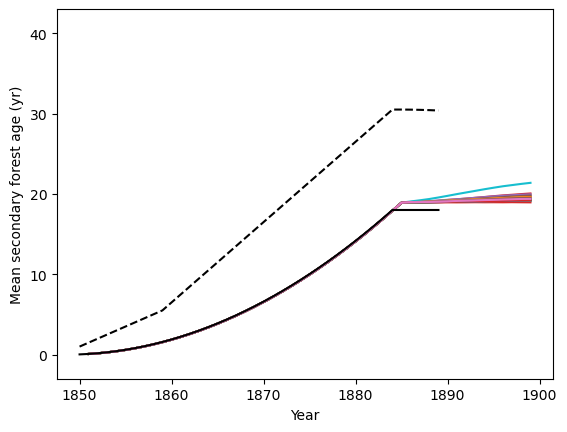

In [47]:
# Plot annual averaged secondary forest age
for i in np.arange(0,nens):
    plt.plot(ax_yr[1:nyr], age_yr[i,1:nyr])

ax_yr = np.arange(1850,2020)    
plt.plot(ax_yr[0:40], hyperthetical_curve[0:40], 'k-')
plt.plot(ax_yr[0:40], hyperthetical_curve_noweight[0:40], 'k--')
# plt.legend(['Candidate 1', 'Candidate 2', 'Theoretical'])
plt.ylim([-3, 43])
plt.xlabel('Year')
plt.ylabel('Mean secondary forest age (yr)')

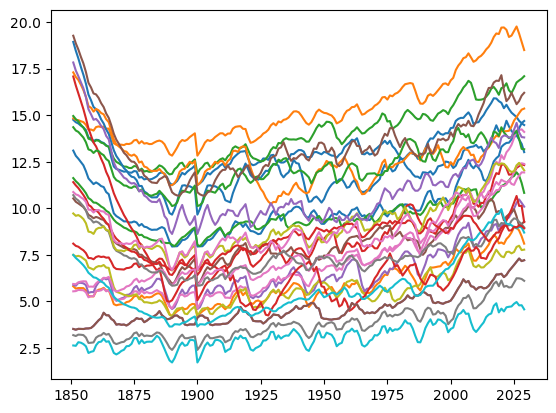

In [50]:
# Plot GPP., vegc time series
for i in np.arange(0,27):
    plt.plot(ax_yr[1:nyr], arr_vegc_nl_mean[i,1:nyr]+arr_vegc_bl_mean[i,1:nyr])

In [51]:
all_2010 = arr_vegc_nl_mean[:,160]+arr_vegc_bl_mean[:,160]

In [72]:
arr_vegc_nl_mean[5,163:170]

array([3.29141521, 3.33538699, 3.38065505, 3.44080615, 3.50475621,
       3.53687596, 3.53220868])

In [73]:
arr_vegc_bl_mean[5,163:170]

array([6.50721312, 6.7525959 , 6.98218489, 7.06920004, 6.80553675,
       6.24385691, 6.31975174])

In [54]:
all_2013_2019 = arr_vegc_nl_mean[:,163:170]+arr_vegc_bl_mean[:,163:170]


In [59]:
all_2013_2019

array([[11.52863097, 11.45586181, 11.73400879, 12.11422086, 12.51940823,
        12.69000912, 12.80719757],
       [ 7.6793983 ,  7.85209441,  8.04799581,  8.34391022,  8.56034589,
         8.44318628,  8.11790586],
       [10.13110018, 10.3086741 , 10.40911627, 10.42524838, 10.64336896,
        10.82377839, 10.91140819],
       [10.28758669, 10.64603305, 10.78926635, 11.03349113, 11.57726312,
        11.88635659, 11.83492374],
       [ 8.46801209,  8.75535727,  8.79701614,  8.80522442,  9.09712934,
         9.15408945,  8.77159262],
       [ 9.79862833, 10.08798289, 10.36283994, 10.51000619, 10.31029296,
         9.78073287,  9.85196042],
       [10.89539909, 11.22663641, 11.3826623 , 11.69295168, 12.22678423,
        12.50078821, 12.35393381],
       [ 5.0632937 ,  5.36512446,  5.53028536,  5.68101954,  5.94822979,
         6.06359768,  5.81678867],
       [ 6.82996154,  6.97609091,  7.08309102,  7.22695661,  7.513726  ,
         7.77674341,  7.58404255],
       [ 3.87095356,  4.1598

In [58]:
np.nanmean(all_2013_2019, axis=0)

array([3.51803191, 3.53874719, 3.55304296, 3.58021461, 3.58241996,
       3.56062817, 3.58410489])

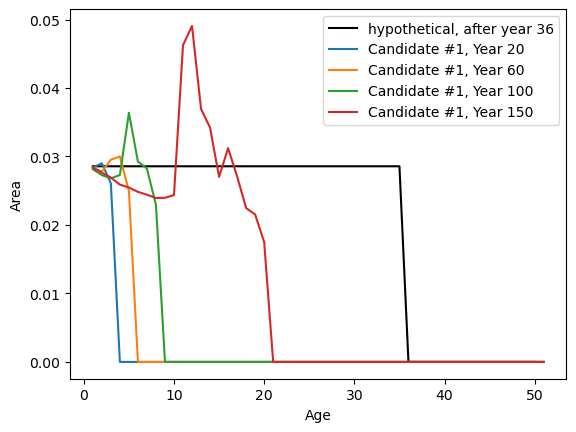

In [41]:
# Quick check of age structure from one of the candidates
plt.plot(age_bin[0:50], hyper_age_dist[:], 'k-')
plt.plot(age_bin, age_annual_mean[25,2,:])
plt.plot(age_bin, age_annual_mean[25,4,:])
plt.plot(age_bin, age_annual_mean[25,7,:])
plt.plot(age_bin, age_annual_mean[25,19,:])
plt.xlabel('Age')
plt.ylabel('Area')
# plt.ylim([-0.01, 0.26])
plt.legend(['hypothetical, after year 36', 'Candidate #1, Year 20', 'Candidate #1, Year 60', 'Candidate #1, Year 100', 'Candidate #1, Year 150'])

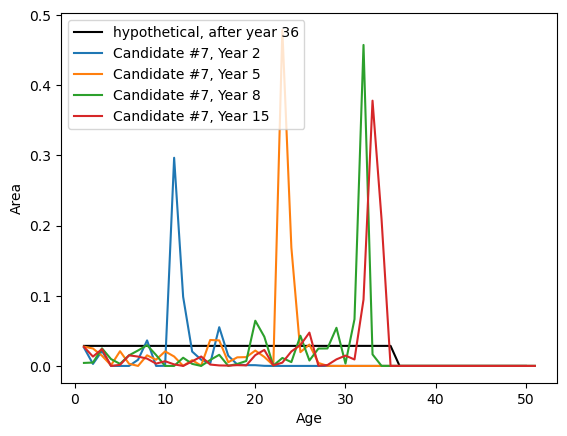

In [16]:
# Quick check of age structure from one of the candidates
plt.plot(age_bin[0:50], hyper_age_dist[:], 'k-')
plt.plot(age_bin, age_annual_mean[6,20,:])
plt.plot(age_bin, age_annual_mean[6,40,:])
plt.plot(age_bin, age_annual_mean[6,70,:])
plt.plot(age_bin, age_annual_mean[6,140,:])
plt.xlabel('Age')
plt.ylabel('Area')
# plt.ylim([-0.01, 0.26])
plt.legend(['hypothetical, after year 36', 'Candidate #7, Year 2', 'Candidate #7, Year 5', 'Candidate #7, Year 8', 'Candidate #7, Year 15'])

### Plot heat map of patch age

In [12]:
############################################################
### open the file and read in coordinate data
############################################################

## define the sizes of each dimension
## since the model simulation restarts at every 30 years
## time variable from historical file is disrupted
## create the axis on my own, in the unit of years.
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## because the bin edges read in define the lower edges, add a last index to each to
## represent the upper edge of the distribution (even though there isn't one, really)
# time = np.append(time,time[ntim-1]+31.0)
patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)


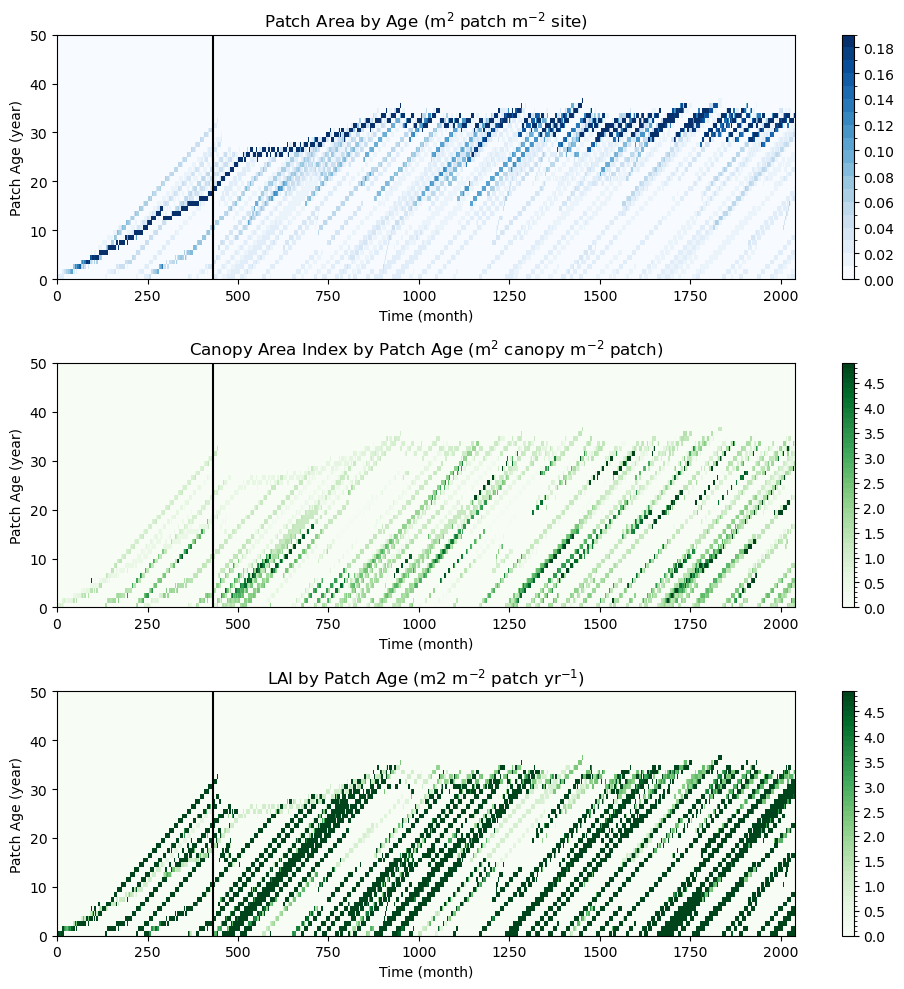

In [24]:
# Need to pick one ensemble
# candidates with age structure problem: 5, 6, 9, 13, 14, 15, 19
iens = 6
# 0 - monthly, 1 - annual
plot_mode = 0

if(plot_mode == 0):
    time = np.arange(0,2041)
    ntim = len(time)

    # productivity and canopy structure as a function of patch age
    # rename of certain variables
    # GPP_BY_AGE [not available as default output any more] 
    LAI_BY_AGE = arr_lai_age[iens, :, :, :]
    PATCH_AREA_BY_AGE = arr_age[iens, :, :, :] + 1e-7
    CANOPY_AREA_BY_AGE = arr_can_area[iens, :, :, :]

    # population numbers and basal area as a functino of cohort size
    BA_SCLS = arr_ba[iens, :, :, :]
    NPLANT_CANOPY_SCLS = arr_num_can_sz[iens, :, :, :]
    NPLANT_UNDERSTORY_SCLS = arr_num_ustory_sz[iens, :, :, :]

    # growth and mortality rates as a function of plant size
    DDBH_CANOPY_SCLS = arr_ddbh_can_sz[iens, :, :, :]
    DDBH_UNDERSTORY_SCLS = arr_ddbh_ustory_sz[iens, :, :, :]
    MORTALITY_CANOPY_SCLS = arr_mort[iens, :, :, :]
    MORTALITY_UNDERSTORY_SCLS = arr_mort_ustory[iens, :, :, :]

else:
    time = np.arange(1850,2020)
    time_act = np.arange(1850,2019)
    ntim = len(time_act)
    
    LAI_BY_AGE = np.zeros((ntim, nagebins, 1)) 
    PATCH_AREA_BY_AGE = np.zeros((ntim, nagebins, 1))
    CANOPY_AREA_BY_AGE = np.zeros((ntim, nagebins, 1))

    BA_SCLS = np.zeros((ntim, nsizebins, 1))
    NPLANT_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    NPLANT_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))

    DDBH_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    DDBH_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))
    MORTALITY_CANOPY_SCLS = np.zeros((ntim, nsizebins, 1))
    MORTALITY_UNDERSTORY_SCLS = np.zeros((ntim, nsizebins, 1))

    for iyr in time_act:
        idx = 12*(iyr - 1850)
        LAI_BY_AGE[iyr-1850,:,:] = np.nanmean(arr_lai_age[iens, idx:idx+12, :, :], axis=0) 
        PATCH_AREA_BY_AGE[iyr-1850,:,:] = np.nanmean(arr_age[iens, idx:idx+12, :, :], axis=0) + 1e-7
        CANOPY_AREA_BY_AGE[iyr-1850,:,:] = np.nanmean(arr_can_area[iens, idx:idx+12, :, :], axis=0)

        # population numbers and basal area as a functino of cohort size
        BA_SCLS[iyr-1850,:,:] = np.nanmean(arr_ba[iens, idx:idx+12, :, :], axis=0)
        NPLANT_CANOPY_SCLS[iyr-1850,:,:] = np.nanmean(arr_num_can_sz[iens, idx:idx+12, :, :], axis=0)
        NPLANT_UNDERSTORY_SCLS[iyr-1850,:,:] = np.nanmean(arr_num_ustory_sz[iens, idx:idx+12, :, :], axis=0)

        # growth and mortality rates as a function of plant size
        DDBH_CANOPY_SCLS[iyr-1850,:,:] = np.nanmean(arr_ddbh_can_sz[iens, idx:idx+12, :, :], axis=0)
        DDBH_UNDERSTORY_SCLS[iyr-1850,:,:] = np.nanmean(arr_ddbh_ustory_sz[iens, idx:idx+12, :, :], axis=0)
        MORTALITY_CANOPY_SCLS[iyr-1850,:,:] = np.nanmean(arr_mort[iens, idx:idx+12, :, :], axis=0)
        MORTALITY_UNDERSTORY_SCLS[iyr-1850,:,:] = np.nanmean(arr_mort_ustory[iens, idx:idx+12, :, :], axis=0)
    
############################################################
### first, look at the productivity and canopy structure
############################################################

# set up the page
fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, figsize=(10, 10))

## set up the first plot: the fractional area of patches of a given age range
levels = np.arange(0.,0.2, 0.01)
cmap = plt.get_cmap('Blues')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax0.pcolormesh(time, patch_age_bins, PATCH_AREA_BY_AGE[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax0)
f1ax0.set_title(r'Patch Area by Age (m$^2$ patch m$^{-2}$ site)')
f1ax0.set_ylabel('Patch Age (year)')
f1ax0.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax0.set_xlabel('Time (month)')
    f1ax0.axvline(x = 432, color = 'k')
else:
    f1ax0.set_xlabel('Time (year)')
    f1ax0.set_xlim([1850, 2020])
    f1ax0.axvline(x = 1886, color = 'k')

# Mask out the canopy area and LAI with patch area less than 1e-2
CANOPY_AREA_BY_AGE[PATCH_AREA_BY_AGE<0.01] = 0.0
LAI_BY_AGE[PATCH_AREA_BY_AGE<0.01] = 0.0

## set up the second plot: the canopy coverage of patches of a given age (where 1 means canopy closure)
levels = np.arange(0.,5.0, 0.1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax1.pcolormesh(time, patch_age_bins, (CANOPY_AREA_BY_AGE / PATCH_AREA_BY_AGE)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax1)
f1ax1.set_title(r'Canopy Area Index by Patch Age (m$^2$ canopy m$^{-2}$ patch)')
f1ax1.set_ylabel('Patch Age (year)')
f1ax1.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax1.set_xlabel('Time (month)')
    f1ax1.axvline(x = 432, color = 'k')
else:
    f1ax1.set_xlabel('Time (year)')
    f1ax1.set_xlim([1850, 2020])
    f1ax1.axvline(x = 1886, color = 'k')


## set up the third plot: the GPP, conditional on patch age
levels = np.arange(0., 5.0, 0.1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f1ax2.pcolormesh(time, patch_age_bins, (LAI_BY_AGE )[:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax2)
f1ax2.set_title(r'LAI by Patch Age (m$2$ m$^{-2}$ patch yr$^{-1}$)')
f1ax2.set_ylabel('Patch Age (year)')
f1ax2.set_ylim([0, 50])
if(plot_mode == 0):
    f1ax2.set_xlabel('Time (month)')
    f1ax2.axvline(x = 432, color = 'k')
else:
    f1ax2.set_xlabel('Time (year)')
    f1ax2.set_xlim([1850, 2020])
    f1ax2.axvline(x = 1886, color = 'k')

# show the plot
fig1.tight_layout()
plt.show()



In [20]:
## Redefine the cohort size bins
cohort_size_bins = np.array([0.00000000e+00, 7.50000000e+00, 1.50000000e+01,
                   2.00000000e+01, 3.00000000e+01, 4.00000000e+01,
                   5.00000000e+01, 6.00000000e+01, 7.00000000e+01,
                   8.00000000e+01, 9.00000000e+01, 1.00000000e+02,
                   110, 120])

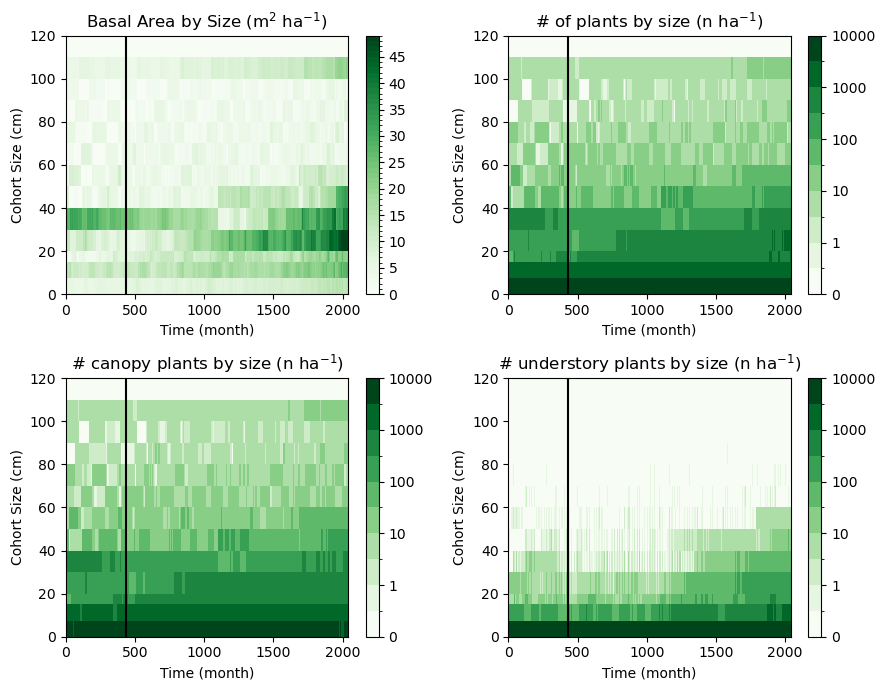

/tmp/ipykernel_1299671/3056585712.py:66: RuntimeWarning: invalid value encountered in divide
  im = f3ax0.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1299671/3056585712.py:77: RuntimeWarning: invalid value encountered in divide
  im = f3ax1.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1299671/3056585712.py:88: RuntimeWarning: invalid value encountered in divide
  im = f3ax2.pcolormesh(time, cohort_size_bins, (MORTALITY_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1299671/3056585712.py:99: RuntimeWarning: divide by zero encountered in divide
  im = f3ax3.pcolormesh(time, cohort_size_bins, (MORTALITY_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
/tmp/ipykernel_1299671/3056585712.py:99: RuntimeWarning: invalid valu

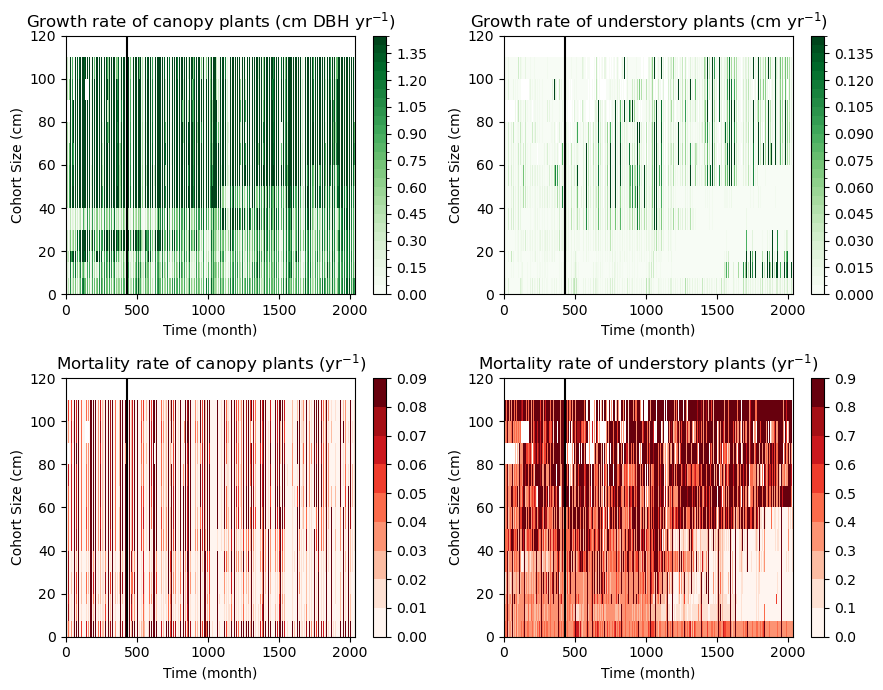

In [25]:
############################################################
### next, look at the evolution of the plant size structure
############################################################

# set up the page
fig2, ((f2ax0, f2ax1), (f2ax2, f2ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: evolution of basal area of plants of a given size
levels = np.arange(0.,50, 1)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax0.pcolormesh(time, cohort_size_bins, 1e5*BA_SCLS[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax0)
f2ax0.axvline(x = 432, color = 'k')
f2ax0.set_title(r'Basal Area by Size (m$^2$ ha$^{-1}$)')
f2ax0.set_xlabel('Time (month)')
f2ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: evolution of the population density of plants of a given size
# sum the canopy and understory plants to get size distribution of all plants
levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.]) # do a pseudo-log scale here
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f2ax1.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_CANOPY_SCLS + NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax1)
f2ax1.axvline(x = 432, color = 'k')
f2ax1.set_title(r'# of plants by size (n ha$^{-1}$)')
f2ax1.set_xlabel('Time (month)')
f2ax1.set_ylabel('Cohort Size (cm)')

## set up the third plot: evolution of the population density of canopy plants of a given size
# use same levels & colorbar as second plot above
im = f2ax2.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax2)
f2ax2.axvline(x = 432, color = 'k')
f2ax2.set_title(r'# canopy plants by size (n ha$^{-1}$)')
f2ax2.set_xlabel('Time (month)')
f2ax2.set_ylabel('Cohort Size (cm)')

## set up the fourth plot: evolution of the population density of understory plants of a given size
# use same levels & colorbar as second plot above
im = f2ax3.pcolormesh(time, cohort_size_bins, 1e5*(NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig2.colorbar(im, ax=f2ax3)
f2ax3.axvline(x = 432, color = 'k')
f2ax3.set_title(r'# understory plants by size (n ha$^{-1}$)')
f2ax3.set_xlabel('Time (month)')
f2ax3.set_ylabel('Cohort Size (cm)')

# show the plot
fig2.tight_layout()
plt.show()

############################################################
### next, look at the growth and mortality rates
### for all of these rates, you need to divide the rate by the population
### size in post-processing to get meaningful units
############################################################

# set up the page
fig3, ((f3ax0, f3ax1), (f3ax2, f3ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))

## set up the first plot: growth rate (in diameter increment) in the canopy
levels = np.arange(0.,1.5, 0.05)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax0.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax0)
f3ax0.axvline(x = 432, color = 'k')
f3ax0.set_title(r'Growth rate of canopy plants (cm DBH yr$^{-1}$)')
f3ax0.set_xlabel('Time (month)')
f3ax0.set_ylabel('Cohort Size (cm)')

## set up the second plot: growth rate in the understory, units as above
levels = np.arange(0.,0.15, 0.005)
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax1.pcolormesh(time, cohort_size_bins, 100.0*(DDBH_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax1)
f3ax1.axvline(x = 432, color = 'k')
f3ax1.set_title(r'Growth rate of understory plants (cm yr$^{-1}$)')
f3ax1.set_xlabel('Time (month)')
f3ax1.set_ylabel('Cohort Size (cm)')

## set up the third plot: mortality rate in the canopy, in units of fraction of trees per year of a given size class and canopy position
levels = np.arange(0.,0.1, 0.01)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax2.pcolormesh(time, cohort_size_bins, (MORTALITY_CANOPY_SCLS / NPLANT_CANOPY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax2)
f3ax2.axvline(x = 432, color = 'k')
f3ax2.set_title(r'Mortality rate of canopy plants (yr$^{-1}$)')
f3ax2.set_xlabel('Time (month)')
f3ax2.set_ylabel('Cohort Size (cm)')

## set up the fourth plot: mortality rate in the understory, units as above
levels = np.arange(0.,1.0, 0.1)
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = f3ax3.pcolormesh(time, cohort_size_bins, (MORTALITY_UNDERSTORY_SCLS / NPLANT_UNDERSTORY_SCLS)[:,:,0].transpose(), cmap=cmap, norm=norm)
fig3.colorbar(im, ax=f3ax3)
f3ax3.axvline(x = 432, color = 'k')
f3ax3.set_title(r'Mortality rate of understory plants (yr$^{-1}$)')
f3ax3.set_xlabel('Time (month)')
f3ax3.set_ylabel('Cohort Size (cm)')

# show the plot
fig3.tight_layout()
plt.show()

In [27]:
age_annual_mean = np.zeros((2,40,7))
age_patch_mean = np.zeros((2,40,7))
for iyr in np.arange(0,40):
    age_annual_mean[:,iyr,:] = np.nanmean(arr_age[:,12*iyr:12+12*iyr,:,0], axis=1)
    age_patch_mean[:,iyr,:] = np.nanmean(arr_age_patch[:,12*iyr:12+12*iyr,:,0], axis=1)

In [7]:
age_1850_mean = np.nanmean(np.nanmean(arr_age[:,0:120,:,0], axis=0), axis=0)
age_1980_mean = np.nanmean(np.nanmean(arr_age[:,1500:1620, :, 0], axis = 0), axis=0)
age_1850_std = np.nanstd(arr_age[:,0:120,:,0], axis=0)
age_1980_std = np.nanstd(arr_age[:,1500:1620, :, 0], axis = 0)

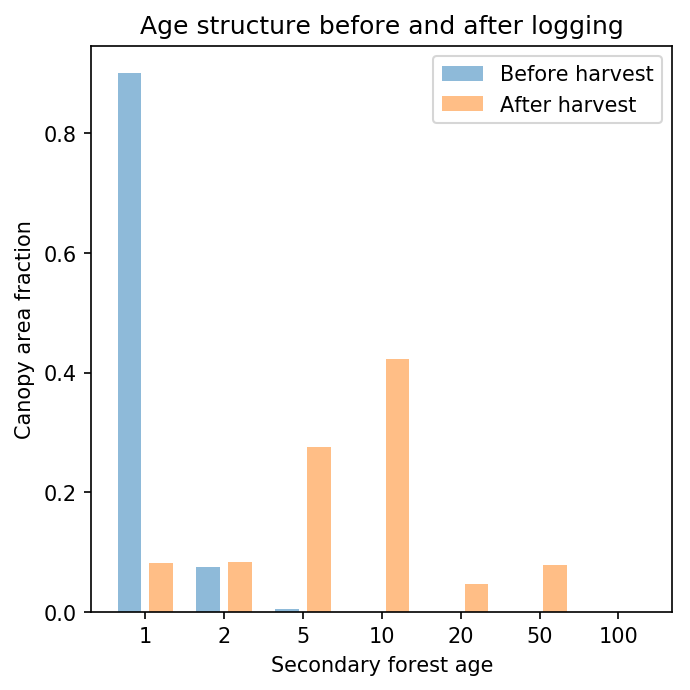

In [8]:
# Barplot to show age distribution
fig = plt.figure(figsize=(5,5), dpi=150)
objects = ('1', '2', '5', '10', '20', '50', '100')
y_pos = np.arange(len(objects))
y_pos_1 = np.arange(len(objects))-0.2
y_pos_2 = np.arange(len(objects))+0.2

plt.bar(y_pos_1, age_1850_mean, align='center', alpha=0.5, width = 0.3)
plt.bar(y_pos_2, age_1980_mean, align='center', alpha=0.5, width = 0.3)
plt.xticks(y_pos, objects)
plt.ylabel('Canopy area fraction')
plt.xlabel('Secondary forest age')
plt.title('Age structure before and after logging')
plt.legend(['Before harvest', 'After harvest'])


Text(0.5,0,'Age')

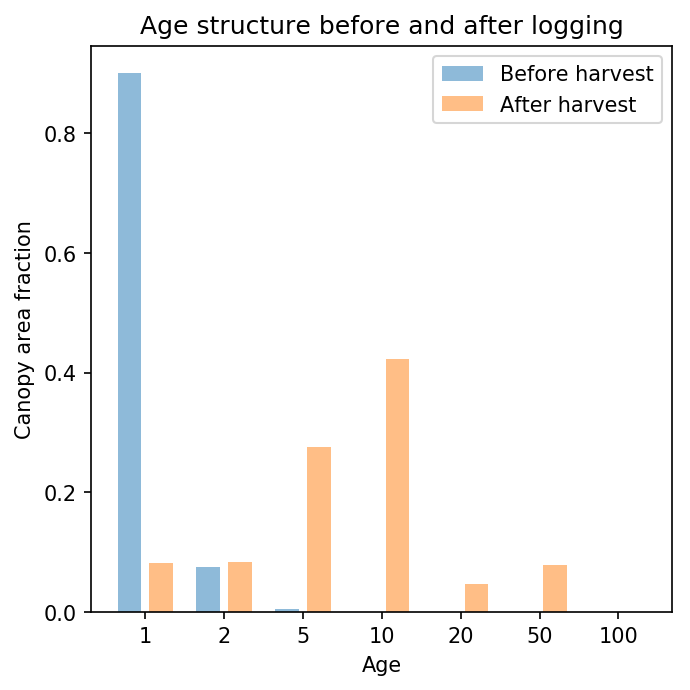

In [9]:
# Barplot to show age distribution
fig = plt.figure(figsize=(5,5), dpi=150)
objects = ('1', '2', '5', '10', '20', '50', '100')
y_pos = np.arange(len(objects))
y_pos_1 = np.arange(len(objects))-0.2
y_pos_2 = np.arange(len(objects))+0.2

plt.bar(y_pos_1, age_1850_mean, align='center', alpha=0.5, width = 0.3)
plt.bar(y_pos_2, age_1980_mean, align='center', alpha=0.5, width = 0.3)
plt.xticks(y_pos, objects)
plt.ylabel('Canopy area fraction')
plt.title('Age structure before and after logging')
plt.legend(['Before harvest', 'After harvest'])
plt.xlabel('Age')

### Check harvested carbon and other C variables

(7.5, 30.0)

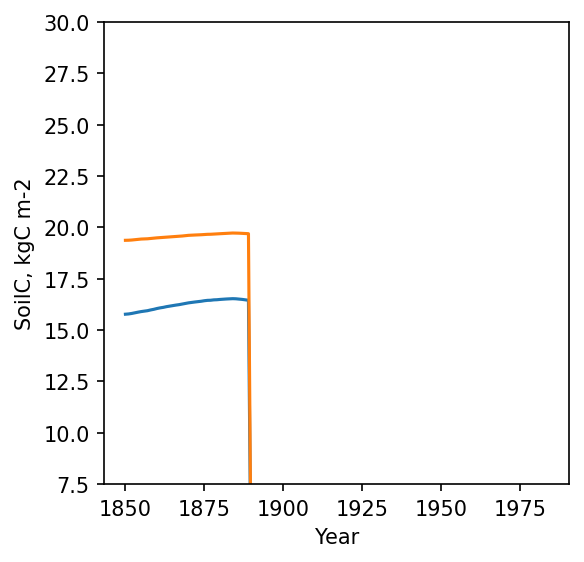

In [ ]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,1985)
for i in np.arange(0,2):
    plt.plot(ax_yr, arr_soilc_mean[i,:])
plt.xlabel('Year')
plt.ylabel('SoilC, kgC m-2')
plt.ylim([7.5, 30])

(0.0, 20.0)

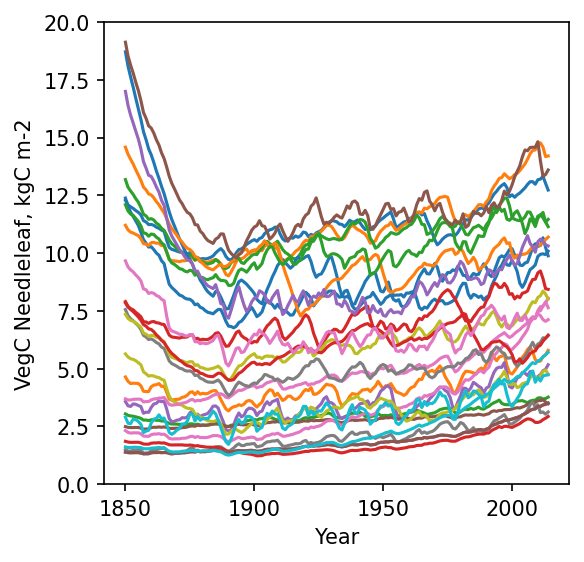

In [62]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,2015)
for i in np.arange(0,27):
    plt.plot(ax_yr[0:165], arr_vegc_nl_mean[i,0:165])
plt.xlabel('Year')
plt.ylabel('VegC Needleleaf, kgC m-2')
plt.ylim([0, 20])

(0.0, 15.0)

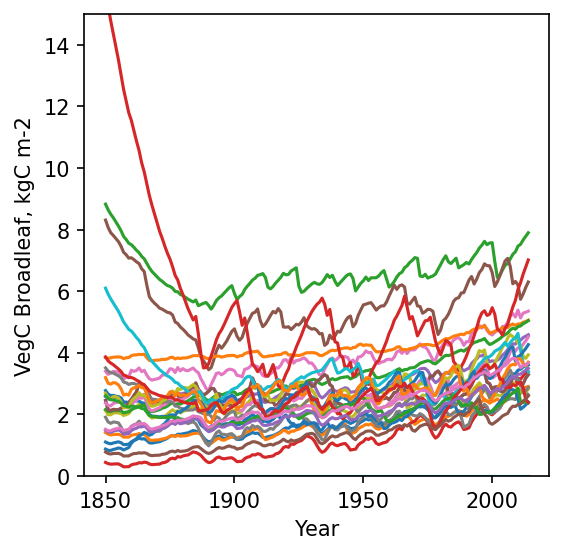

In [63]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax_yr = np.arange(1850,2015)
for i in np.arange(0,27):
    plt.plot(ax_yr[0:165], arr_vegc_bl_mean[i,0:165])
plt.xlabel('Year')
plt.ylabel('VegC Broadleaf, kgC m-2')
plt.ylim([0, 15])

### Check the vegetation size-class structure and age structure and have a second round of picking candidates

In [2]:
oak_pine_df = pd.read_csv('Size_distributions_Puebla.csv')

In [3]:
oak_pine_df

,lower_bin_edge,All,Oak,Pine
0,7.5,829.444444,284.444444,210.000000
1,15.0,227.222222,74.444444,86.111111
2,20.0,214.444444,70.000000,63.888889
3,30.0,124.444444,30.555556,53.333333
4,40.0,50.555556,6.111111,36.666667
5,50.0,33.333333,2.777778,28.888889
6,60.0,0.000000,0.000000,0.000000
